In [1]:
import pandas as pd
from sklearn import model_selection
from sklearn import tree, linear_model, svm, ensemble, metrics
from matplotlib import pyplot as plt
import xgboost as xgb
import scipy
import numpy as np

%matplotlib inline

In [3]:
DATA_FILE = "data/data_table_percentile.tsv"
df = pd.read_csv(DATA_FILE, sep="\t")
print df.head(5)

label = df["sensitivity_label"].copy()
data = df.drop("sensitivity_label", axis=1)
data.set_index(data.cell_drug_pair, inplace=True)
data.drop("cell_drug_pair", axis=1, inplace=True)
data.drop("cell", axis=1, inplace=True)
data.drop("drug", axis=1, inplace=True)

   sensitivity_label cell_drug_pair cell drug  G10_targeted  G10_active  \
0           0.499529           C6D0   C6   D0             0    0.543785   
1           0.457755           C6D3   C6   D3             0    0.543785   
2           0.813710           C6D4   C6   D4             0    0.543785   
3           0.640917           C6D5   C6   D5             0    0.543785   
4           0.794002           C6D7   C6   D7             0    0.543785   

   G10_essential  G100_targeted  G100_active  G100_essential      ...        \
0       0.288283              0     0.297476        0.981071      ...         
1       0.288283              0     0.297476        0.981071      ...         
2       0.288283              0     0.297476        0.981071      ...         
3       0.288283              0     0.297476        0.981071      ...         
4       0.288283              0     0.297476        0.981071      ...         

   G94_essential  G95_targeted  G95_active  G95_essential  G96_targeted  \

In [4]:
Classifiers = {"Random Forest": ensemble.RandomForestRegressor(),
               "SVM": svm.SVR(kernel="rbf"), 
               "XGBoost": xgb.XGBRegressor(n_estimators=200),
               "Linear": linear_model.LinearRegression()}

In [5]:
kf = model_selection.KFold(n_splits=5)
mse_result_df = pd.DataFrame()
spearman_result_df = pd.DataFrame()
fold_num = 0
for train, test in kf.split(df):
    fold_num += 1
    tr, val = model_selection.train_test_split(train, test_size=0.2, random_state=1)
    
    x_train = data.iloc[tr]
    y_train = label.iloc[tr].as_matrix()
    x_val = data.iloc[val]
    y_val = label.iloc[val].as_matrix()
    x_test = data.iloc[test]
    y_test = label.iloc[test].as_matrix()
        
    for classifier_name, clf in Classifiers.iteritems():
        clf.fit(x_train, y_train)
        prediction = clf.predict(x_val)
        mse = metrics.mean_squared_error(prediction, y_val)
        rho = scipy.stats.spearmanr(prediction, y_val)
        mse_result_df.loc[fold_num, classifier_name] = mse
        spearman_result_df.loc[fold_num, classifier_name] = rho[0]
        
        
print "mse\n", mse_result_df
print "spearman rank correlation\n", spearman_result_df


mse
    XGBoost       SVM  Random Forest    Linear
1  0.024637  0.028992       0.029181  0.026963
2  0.023017  0.025956       0.028001  0.025345
3  0.024507  0.026934       0.028383  0.026526
4  0.023725  0.026327       0.027700  0.026960
5  0.023798  0.028354       0.025941  0.027651
spearman rank correlation
    XGBoost       SVM  Random Forest    Linear
1  0.787341  0.736325       0.737157  0.767537
2  0.807172  0.784656       0.764998  0.796401
3  0.820436  0.808847       0.789839  0.810788
4  0.837341  0.826833       0.803544  0.821273
5  0.824228  0.791933       0.805277  0.803228


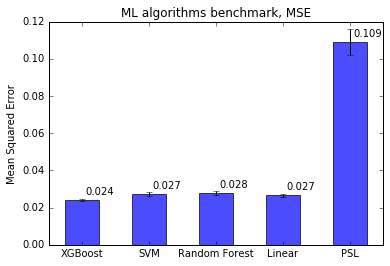

In [11]:
psl_mean = 0.109
psl_std = 0.007
means = mse_result_df.mean()
means["PSL"] = psl_mean
stds = mse_result_df.std()
stds["PSL"] = psl_std
            
ax = means.plot.bar(yerr=stds, alpha=0.7, rot=0)
ax.set_ylabel("Mean Squared Error")
for rect in ax.patches:
    height = rect.get_height()
    height_label = "%.3f" % height
    ax.text(rect.get_x() + rect.get_width()/2 + 0.05, height + 0.003, height_label)
ax.set_title("ML algorithms benchmark, MSE")
plt.savefig("../plots/ benchmark.png", ppi=200)

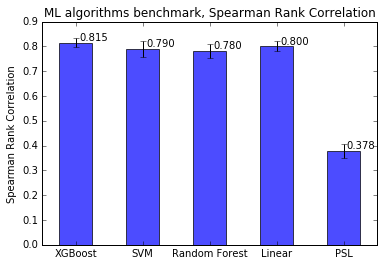

In [12]:
psl_mean = 0.378
psl_std = 0.030
means = spearman_result_df.mean()
means["PSL"] = psl_mean
stds = spearman_result_df.std()
stds["PSL"] = psl_std
            
ax = means.plot.bar(yerr=stds, alpha=0.7, rot=0)
ax.set_ylabel("Spearman Rank Correlation")
for rect in ax.patches:
    height = rect.get_height()
    height_label = "%.3f" % height
    ax.text(rect.get_x() + rect.get_width()/2 + 0.05, height + 0.01, height_label)
ax.set_title("ML algorithms benchmark, Spearman Rank Correlation")
plt.savefig("../plots/benchmark_spearman.png", ppi=200)

In [19]:
### this part is just taking out one random gene
def one_gene_benchmark(file_name, gene_name,
                       psl_mse_mean = 0.272, psl_mse_std = 0.013, 
                       psl_rho_mean = 0.342, psl_rho_std = 0.054):
    
    df = pd.read_csv(file_name, sep="\t")
    label = df["sensitivity_label"].copy()
    data = df.drop("sensitivity_label", axis=1)
    data.set_index(data.cell_drug_pair, inplace=True)
    data.drop("cell_drug_pair", axis=1, inplace=True)
    data.drop("cell", axis=1, inplace=True)
    data.drop("drug", axis=1, inplace=True)

    kf = model_selection.KFold(n_splits=5)
    mse_result_df = pd.DataFrame()
    spearman_result_df = pd.DataFrame()
    fold_num = 0
    for train, test in kf.split(df):
        fold_num += 1
        tr, val = model_selection.train_test_split(train, test_size=0.2, random_state=0)

        x_train = data.iloc[tr]
        y_train = label.iloc[tr].as_matrix()
        x_val = data.iloc[val]
        y_val = label.iloc[val].as_matrix()
        x_test = data.iloc[test]
        y_test = label.iloc[test].as_matrix()

        for classifier_name, clf in Classifiers.iteritems():
            clf.fit(x_train, y_train)
            prediction = clf.predict(x_val)
            mse = metrics.mean_squared_error(prediction, y_val)
            rho = scipy.stats.spearmanr(prediction, y_val)
            mse_result_df.loc[fold_num, classifier_name] = mse
            spearman_result_df.loc[fold_num, classifier_name] = rho[0]
    
    plt.figure(1)
    means = mse_result_df.mean()
    means["PSL"] = psl_mse_mean
    stds = mse_result_df.std()
    stds["PSL"] = psl_mse_std

    ax = means.plot.bar(yerr=stds, alpha=0.7, rot=0)
    ax.set_ylabel("Mean Squared Error")
    for rect in ax.patches:
        height = rect.get_height()
        height_label = "%.3f" % height
        ax.text(rect.get_x() + rect.get_width()/2 + 0.05, height + 0.003, height_label)
    ax.set_title("randomly selecting gene, {0}, MSE".format(gene_name))
    plt.savefig("../plots/{0}_benchmark_mse.png".format(gene_name), ppi=200)

    plt.figure(2)
    means = spearman_result_df.mean()
    means["PSL"] = psl_rho_mean
    stds = spearman_result_df.std()
    stds["PSL"] = psl_rho_std

    ax = means.plot.bar(yerr=stds, alpha=0.7, rot=0)
    ax.set_ylabel("Spearman rank correlation")
    for rect in ax.patches:
        height = rect.get_height()
        height_label = "%.3f" % height
        ax.text(rect.get_x() + rect.get_width()/2 + 0.05, height + 0.003, height_label)
    ax.set_title("randomly selecting gene, {0}, spearman rank correlation".format(gene_name))
    plt.savefig("../plots/{0}_benchmark_rho.png".format(gene_name), ppi=200)

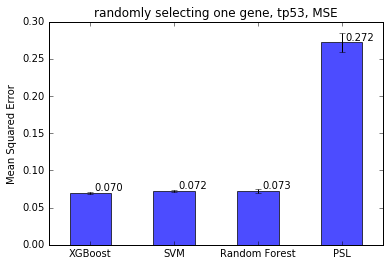

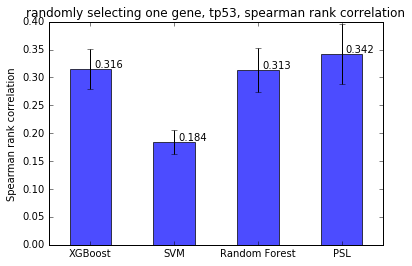

In [17]:
file_name = "data_table_percentile_G60.tsv"
gene_name = "tp53"
one_gene_benchmark(file_name, gene_name,
                   psl_mse_mean = 0.272, psl_mse_std=0.013, 
                   psl_rho_mean = 0.342, psl_rho_std=0.054)

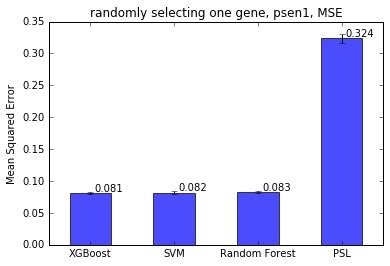

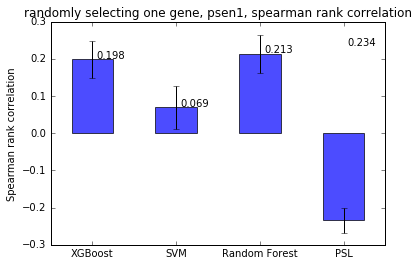

In [18]:
file_name = "data_table_percentile_G94.tsv"
gene_name = "psen1"
one_gene_benchmark(file_name, gene_name,
                   psl_mse_mean = 0.324, psl_mse_std=0.007, 
                   psl_rho_mean = -0.234, psl_rho_std=0.033)

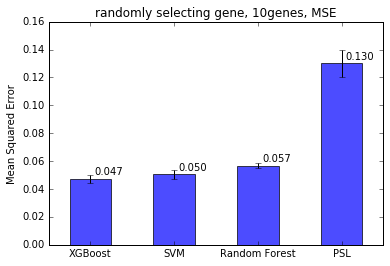

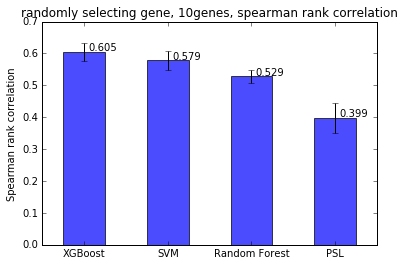

In [20]:
file_name = "data_table_10gene.tsv"
gene_name = "10genes"
one_gene_benchmark(file_name, gene_name,
                   psl_mse_mean = 0.130, psl_mse_std=0.010, 
                   psl_rho_mean = 0.399, psl_rho_std=0.047)

In [35]:
# compare different data scaling
import sys
sys.path.insert(0, '../evaluation/')
import compare_y

def cross_val_result(infer_folder, truth):
    rows = []
    for fold in range(1, 7):
        infer_file = infer_folder + "fold{0}_result.txt".format(fold)
        truth_train_file = truth + "fold{0}_train_truth.txt".format(fold)
        truth_val_file = truth + "fold{0}_val_truth.txt".format(fold)
        infer_df = compare_y.load_data(infer_file)
        truth_train_df = compare_y.load_data(truth_train_file)
        truth_val_df = compare_y.load_data(truth_val_file)
        train_mse, train_rho, _, _ = compare_y.calculate_accuracy(truth_train_df, infer_df)
        val_mse, val_rho, _, _ = compare_y.calculate_accuracy(truth_val_df, infer_df)
        rows.append({"val_mse": val_mse, "val_rho": val_rho})
    df = pd.DataFrame(rows)
    return df


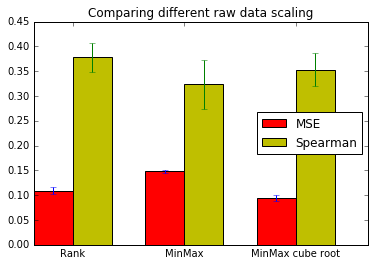

In [49]:
infer_folder = "../psl/result/compare_scaling/min_max/"
truth = "../psl/data/overlap/min_max/seed0/cross_val_6fold/"
psl_df_minmax = cross_val_result(infer_folder, truth)

infer_folder = "../psl/result/compare_scaling/min_max_cuberoot/"
truth = "../psl/data/overlap/min_max_cuberoot/seed0/cross_val_6fold/"
psl_df_minmax_cuberoot = cross_val_result(infer_folder, truth)

infer_folder = "../psl/result/overlap/"
truth = "../psl/data/overlap/seed0/cross_val_6fold/"
psl_df = cross_val_result(infer_folder, truth)

mse_means = []
mse_stds = []
rho_means = []
rho_stds = []
for df in [psl_df, psl_df_minmax, psl_df_minmax_cuberoot]:
    mse_means.append(float(df["val_mse"].mean()))
    mse_stds.append(float(df['val_mse'].std()))
    rho_means.append(float(df["val_rho"].mean()))
    rho_stds.append(float(df['val_rho'].std()))

N = 3
ind = np.arange(N)  # the x locations for the groups
width = 0.35       # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(ind, mse_means, width, color='r', yerr=mse_stds)
rects2 = ax.bar(ind + width, rho_means, width, color='y', yerr=rho_stds)

# add some text for labels, title and axes ticks
ax.set_ylabel('')
ax.set_title('Comparing different raw data scaling')
ax.set_xticks(ind + width)
ax.set_xticklabels(('Rank', 'MinMax', 'MinMax cube root'))

ax.legend((rects1[0], rects2[0]), ('MSE', 'Spearman'), loc="best")

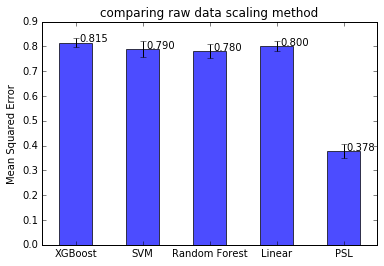

In [32]:
def load_data_to_df(filename):
    df = pd.read_csv(filename, sep="\t")
    return df
#     label = df["sensitivity_label"].copy()
#     data = df.drop("sensitivity_label", axis=1)
#     data.set_index(data.cell_drug_pair, inplace=True)
#     data.drop("cell_drug_pair", axis=1, inplace=True)
#     data.drop("cell", axis=1, inplace=True)
#     data.drop("drug", axis=1, inplace=True)

In [33]:
df_rank = load_data_to_df("data/data_table_percentile.tsv")
df_minmax = load_data_to_df("data/data_table_minmax.tsv")
df_minmax_cuberoot = load_data_to_df("data/data_table_minmax_cuberoot.tsv")

In [34]:
Classifiers = {#"Random Forest": ensemble.RandomForestRegressor(),
               #"SVM": svm.SVR(kernel="rbf"), 
               #"XGBoost": xgb.XGBRegressor(n_estimators=200),
               "Linear": linear_model.LinearRegression()}

In [43]:
dfs = {"rank": df_rank, "minmax": df_minmax, 
       "minmax cube root": df_minmax_cuberoot}

kf = model_selection.KFold(n_splits=5)
mse_result_df = pd.DataFrame()
spearman_result_df = pd.DataFrame()
for scaling_method, df in dfs.iteritems():
    fold_num = 0
    for train, test in kf.split(df):
        fold_num += 1
        tr, val = model_selection.train_test_split(train, test_size=0.2, random_state=1)

        x_train = data.iloc[tr]
        y_train = label.iloc[tr].as_matrix()
        x_val = data.iloc[val]
        y_val = label.iloc[val].as_matrix()
        x_test = data.iloc[test]
        y_test = label.iloc[test].as_matrix()

        for classifier_name, clf in Classifiers.iteritems():
            clf.fit(x_train, y_train)
            prediction = clf.predict(x_val)
            mse = metrics.mean_squared_error(prediction, y_val)
            rho = scipy.stats.spearmanr(prediction, y_val)
            print scaling_method
            print mse, rho
            
            mse_result_df.loc[fold_num, scaling_method] = mse
            spearman_result_df.loc[fold_num, scaling_method] = rho[0]
        
        
print "mse\n", mse_result_df
print "spearman rank correlation\n", spearman_result_df

minmax
0.0269632943962 (0.76753682989723293, 4.4977405242820239e-79)
minmax
0.025344859653 (0.7964014996355564, 3.5763076786125332e-89)
minmax
0.0265258752853 (0.81078801921330512, 7.7188448858042456e-95)
minmax
0.0269599631732 (0.82127331942932491, 2.7720010755369538e-99)
minmax
0.0276510411315 (0.80322833786529624, 8.3829678153333738e-92)
minmax cube root
0.0269632943962 (0.76753682989723293, 4.4977405242820239e-79)
minmax cube root
0.025344859653 (0.7964014996355564, 3.5763076786125332e-89)
minmax cube root
0.0265258752853 (0.81078801921330512, 7.7188448858042456e-95)
minmax cube root
0.0269599631732 (0.82127331942932491, 2.7720010755369538e-99)
minmax cube root
0.0276510411315 (0.80322833786529624, 8.3829678153333738e-92)
rank
0.0269632943962 (0.76753682989723293, 4.4977405242820239e-79)
rank
0.025344859653 (0.7964014996355564, 3.5763076786125332e-89)
rank
0.0265258752853 (0.81078801921330512, 7.7188448858042456e-95)
rank
0.0269599631732 (0.82127331942932491, 2.7720010755369538e-99

         minmax  minmax cube root      rank
count  5.000000          5.000000  5.000000
mean   0.026689          0.026689  0.026689
std    0.000853          0.000853  0.000853
min    0.025345          0.025345  0.025345
25%    0.026526          0.026526  0.026526
50%    0.026960          0.026960  0.026960
75%    0.026963          0.026963  0.026963
max    0.027651          0.027651  0.027651


NameError: name 'mse_means' is not defined

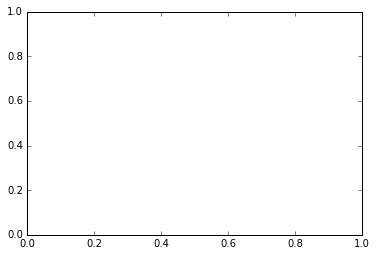

In [42]:
print mse_result_df.describe()
N = 3
ind = np.arange(N)  # the x locations for the groups
width = 0.35       # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(ind, mse_means, width, color='r', yerr=mse_stds)
rects2 = ax.bar(ind + width, rho_means, width, color='y', yerr=rho_stds)

# add some text for labels, title and axes ticks
ax.set_ylabel('')
ax.set_title('Comparing different raw data scaling')
ax.set_xticks(ind + width)
ax.set_xticklabels(('Rank', 'MinMax', 'MinMax cube root'))

ax.legend((rects1[0], rects2[0]), ('MSE', 'Spearman'), loc="best")